The task is to find the schedule for producing food mixes. When we produce two different mixes in a row, we need to spend time on cleaning between them. When we produce the same two mixes, no time for cleaning is required. Factory is working for 20 hours per day, with 3 hours spend on complete cleaning and 1 hour for maintainance. Also, there is a demand in terms of required number of each mix produced.

The goal is to find the optimal schedule such that demand is fullfilled and time spent is minimal.

In [1]:
import numpy as np
from deap import base, creator, tools, algorithms
from deap.algorithms import *
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import multiprocessing as mp
%matplotlib inline

In [2]:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

In [3]:
mixes = ['SM', 'ST', 'DG', 'HC', 'PS', 'ICT', 'CSP', 'VM', 'CMS', 'GS']

Here I copy-pasted code of 'eaSimple' from DEAP.
My changes include:
* Log number of unique individuals in population
* Remove duplicated individuals (or at least decrease their amount)
* Elitism (code taken from [link](https://github.com/PacktPublishing/Hands-On-Genetic-Algorithms-with-Python/blob/master/Chapter04/elitism.py))


I decided to add the number of unique individuals to logs produced by EA for a better evaluation and analysis of algorithms and approaches.

In [4]:
def remove_duplicates(population, toolbox):
    """
    This function removes duplicates from population. Well, almost. It mutates all duplicates
    with the hope that after that we will have less duplicates. Experiments show that this approach
    allows to decrease number of duplicates in each generation to ~5% (instead of 80% without it).
    
    :params population: a population
    :params toolbox: deap toolbox that exposes 'mutate' method
    """
    
    unique, counts = np.unique(population, axis=0, return_counts=True)
    new_population = list(map(creator.Individual, unique))
    counts -= 1
    for ind, count in zip(unique[counts != 0], counts[counts != 0]):
        for i in range(count):
            ind = creator.Individual(ind)
            ind, = toolbox.mutate(ind)
            new_population.append(ind)
    
    return new_population

def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__, log_num_unique=True, 
             should_remove_duplicates=False, elitism=False):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    if log_num_unique:
        logbook.header += ['num_unique_individuals']

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if elitism and halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    if elitism:
        halloffame.update(population)
        hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    if log_num_unique:
        # number of unique individuals in population
        unique = np.unique(population, axis=0)
        record['num_unique_individuals'] = len(unique)
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        n_children = len(population) - hof_size if elitism else len(population)
        offspring = toolbox.select(population, n_children)

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)
        if should_remove_duplicates:
            # remove duplicates
            offspring = remove_duplicates(offspring, toolbox)
        

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if elitism:
            offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        if log_num_unique:
            # number of unique individuals in population
            unique = np.unique(population, axis=0)
            record['num_unique_individuals'] = len(unique)
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

The representation of each individual: a list of length $sum(demand)$ where each mix occurs exatly $demand_i$ times. Then, the goal is to find the optimal permutation or sequence of mixes.

In order to use functions from DEAP, I needed to adapt this representation. For example, it is required for correct work of cxOrdered. Now each individual is a permutation of numbers in the range $[0,sum(demand)]$, and each number is mapped into some mix. For example, there are 7 indices mapped into number 0 (mix 'SM'), 67 indices are mappend into number 2 (mix 'DG').

This mapping is required for calculation of the fitness function.

In [5]:
transitions = [[0,1,1,3,1,3,3,3,3,1],
               [9,0,1,3,9,3,3,3,3,1],
               [9,3,0,3,9,3,3,3,3,1],
               [9,9,9,0,9,3,3,9,3,9],
               [9,9,9,1,0,1,9,9,9,9],
               [9,9,9,1,9,0,9,9,9,9],
               [9,9,9,1,9,1,0,9,3,9],
               [9,1,1,1,9,3,1,0,3,1],
               [9,9,9,3,3,3,3,9,0,9],
               [9,3,3,3,9,3,3,3,3,0]]

demand = np.array([7, 7, 67, 4, 10, 30, 20, 60, 10, 65])

base_individual = []
for i, c in enumerate(demand):
    base_individual.append(np.ones(c) * i)
    
base_individual = np.concatenate(base_individual).astype(np.uint8)
base_individual_indices = list(range(len(base_individual)))

def permute_base_individual():
    return creator.Individual(list(np.random.permutation(base_individual_indices)))

In [6]:
dict(zip(base_individual_indices, base_individual))

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 2,
 15: 2,
 16: 2,
 17: 2,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 2,
 23: 2,
 24: 2,
 25: 2,
 26: 2,
 27: 2,
 28: 2,
 29: 2,
 30: 2,
 31: 2,
 32: 2,
 33: 2,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 39: 2,
 40: 2,
 41: 2,
 42: 2,
 43: 2,
 44: 2,
 45: 2,
 46: 2,
 47: 2,
 48: 2,
 49: 2,
 50: 2,
 51: 2,
 52: 2,
 53: 2,
 54: 2,
 55: 2,
 56: 2,
 57: 2,
 58: 2,
 59: 2,
 60: 2,
 61: 2,
 62: 2,
 63: 2,
 64: 2,
 65: 2,
 66: 2,
 67: 2,
 68: 2,
 69: 2,
 70: 2,
 71: 2,
 72: 2,
 73: 2,
 74: 2,
 75: 2,
 76: 2,
 77: 2,
 78: 2,
 79: 2,
 80: 2,
 81: 3,
 82: 3,
 83: 3,
 84: 3,
 85: 4,
 86: 4,
 87: 4,
 88: 4,
 89: 4,
 90: 4,
 91: 4,
 92: 4,
 93: 4,
 94: 4,
 95: 5,
 96: 5,
 97: 5,
 98: 5,
 99: 5,
 100: 5,
 101: 5,
 102: 5,
 103: 5,
 104: 5,
 105: 5,
 106: 5,
 107: 5,
 108: 5,
 109: 5,
 110: 5,
 111: 5,
 112: 5,
 113: 5,
 114: 5,
 115: 5,
 116: 5,
 117: 5,
 118: 5,
 119: 5,
 120: 5,
 121: 5,
 122: 5,
 12

In [7]:
toolbox = base.Toolbox()
toolbox.register('individual', permute_base_individual)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [8]:
def fitness(individual):
    value = 1
    for i in range(len(individual) - 1):
        i1 = base_individual[individual[i]]
        i2 = base_individual[individual[i + 1]]
        transition_cost = transitions[i1][i2]
        
        if (value + 1) % (3 * 20) == 0: # if it is the last slot in the day - no cleaning is required
            value += 1
        else:
            # if there are other slots and cleaning takes more than time of slots left - we do not need
            # to do all cleaning.
            value += 1 + min(
                60 - (value + 1) % (3 * 20), # time left until the end of the day.
                transition_cost)
        
    return -value, # negative because algorithm will try to maximize fitness, 
                   # but we need to minimize this value

These settings will make up a baseline

In [9]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.01)
toolbox.register('select', tools.selTournament, tournsize=5)

In [10]:
def main(npop=50, ngen=100, cxpb=0.9, mutpb=0.3, log_num_unique=True, should_remove_duplicates=False, elitism=False):
    pop = toolbox.population(n=npop)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('avg', np.mean)
    stats.register('std', np.std)
    stats.register('min', np.min)
    stats.register('max', np.max)
    
    pop, log = eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen,
                        stats=stats, halloffame=hof, verbose=False,
                        log_num_unique=log_num_unique, 
                        should_remove_duplicates=should_remove_duplicates,
                        elitism=elitism)
        
    return pop, log, hof

In [11]:
def n_simulations(n_sims=5, n_gens=3000, npop=50, cxpb=0.9, mutpb=0.3, 
                  log_num_unique=True, 
                  should_remove_duplicates=False, elitism=False):
    logs = []
    best_score = 100000
    best_ind = None
    # run 'n_sims' simulations
    for i in tqdm(range(n_sims)):
        pop, log, hof = main(npop=npop, ngen=n_gens, 
                             log_num_unique=log_num_unique, 
                             should_remove_duplicates=should_remove_duplicates,
                             cxpb=cxpb, mutpb=mutpb,
                             elitism=elitism)
        
        if -log[-1]['max'] < best_score:
            best_ind = hof[0]
            best_score = -log[-1]['max']
        logs.append(log)

    min_logs = list(map(lambda log: list(map(lambda x: x['min'], log)), logs))
    min_logs = np.mean(min_logs, axis=0)
    max_logs = list(map(lambda log: list(map(lambda x: x['max'], log)), logs))
    max_logs = np.mean(max_logs, axis=0)
    avg_logs = list(map(lambda log: list(map(lambda x: x['avg'], log)), logs))
    avg_logs = np.mean(avg_logs, axis=0)
    if log_num_unique:
        num_unique_individuals_logs = list(map(lambda log: list(map(lambda x: x['num_unique_individuals'], log)), logs))
        num_unique_individuals_logs = np.mean(num_unique_individuals_logs, axis=0)
    # visualize evolution
    plt.title(str(-max_logs[-1]))
    plt.plot(-min_logs, color='red', label='max')
    plt.plot(-max_logs, color='orange', label='min')
    plt.plot(-avg_logs, color='blue', label='avg')
    plt.legend(loc='best')
    plt.show()
    
    if log_num_unique:
        plt.title("Number of unique individuals")
        plt.plot(num_unique_individuals_logs, color='blue', label='avg')
        plt.show()
        
    plt.title('Best individual in the last simulation')
    plt.plot(np.array(list(map(lambda x: base_individual[x], best_ind))))
    plt.show()

    return best_ind, pop

Obtain baseline results. We see that we have a lot of duplicated individuals in population. It is a waste of resources and harder exploration. Also, these individuals obtain higher weight in selection, which may not be beneficial because they are not optimal. 

  0%|          | 0/5 [00:00<?, ?it/s]

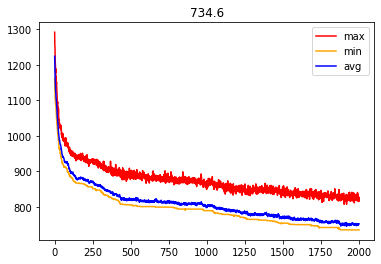

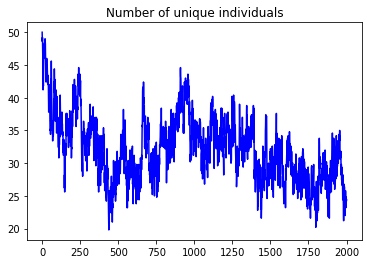

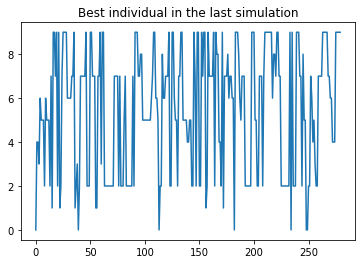

In [12]:
_ = n_simulations(n_sims=5, n_gens=2000, log_num_unique=True, should_remove_duplicates=False, elitism=False)

Therefore, I added a mechanism for removal of duplicated individuals. Here, I just take all duplicates and randomly mutate them. Though it doesn't guarantee that there will be no duplicates at all, it reduces their number significantly. Results show that it helps convergence of the EA.

  0%|          | 0/5 [00:00<?, ?it/s]

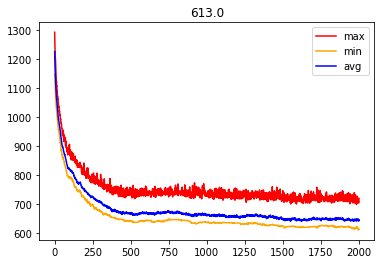

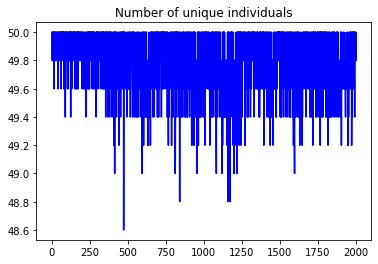

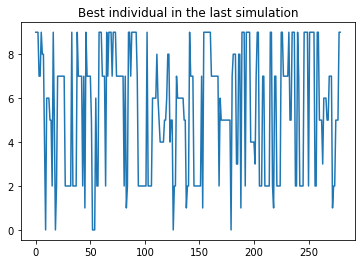

In [13]:
_ = n_simulations(n_sims=5, n_gens=2000, log_num_unique=True, should_remove_duplicates=True)

Adding elitism to algorithm doesn't improve results. However, the curves don't go onto a plateau yet, so given more generations we could obtain a better result. It's just that convergence is slower. Compare this to no elitism - the curves are almost flat after some point.

  0%|          | 0/5 [00:00<?, ?it/s]

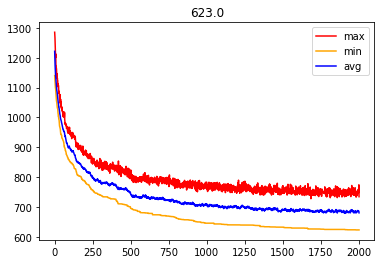

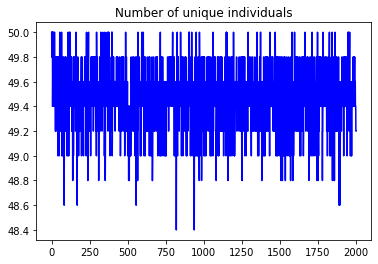

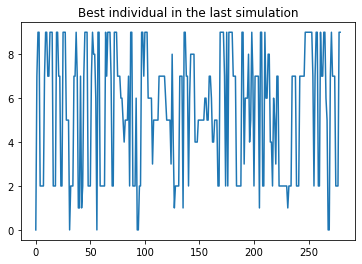

In [14]:
toolbox.register('select', tools.selTournament, tournsize=3)
_ = n_simulations(n_sims=5, n_gens=2000, log_num_unique=True, should_remove_duplicates=True, elitism=True)

Let's check how different values of mutation probability affect the EA performance. A greater mutation rate gives better results, with 0.02 the best

In [15]:
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.02)
toolbox.register('select', tools.selTournament, tournsize=5)

  0%|          | 0/5 [00:00<?, ?it/s]

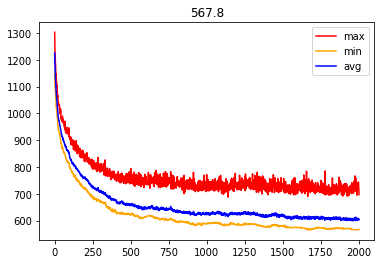

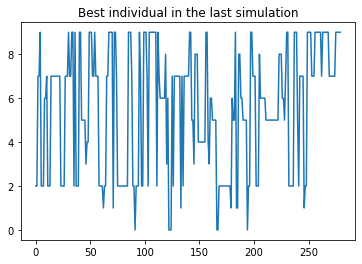

In [16]:
_ = n_simulations(n_sims=5, n_gens=2000, log_num_unique=False, should_remove_duplicates=True)

In [17]:
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.03)

  0%|          | 0/5 [00:00<?, ?it/s]

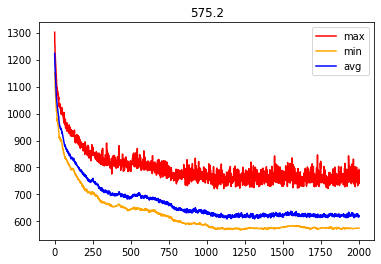

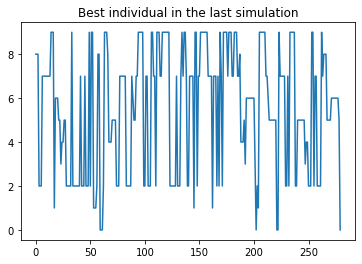

In [18]:
_ = n_simulations(n_sims=5, n_gens=2000, log_num_unique=False, should_remove_duplicates=True)

Let's try Partially Matched crossover instead of Ordered crossover. Ordered crossover gives better results probably because it preserves sequential ordering inside individual better. Intuitively, the less shuffled population is, the less time we need to spend on cleaning.

In [19]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxPartialyMatched)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.02)
toolbox.register('select', tools.selTournament, tournsize=5)

  0%|          | 0/5 [00:00<?, ?it/s]

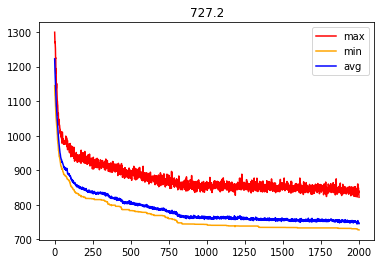

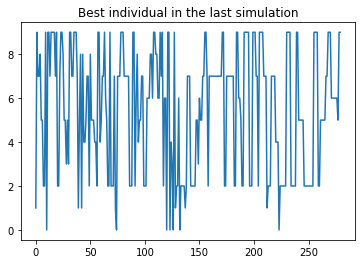

In [20]:
_ = n_simulations(n_sims=5, n_gens=2000, log_num_unique=False, should_remove_duplicates=True, elitism=False)

Now, let's look at mutation. The current option just shuffles elements in the individual-list. But in most of the cases it actually harms the evolution. Obviously, the more we have same mixes in a sequence and the less there are changes in subsequent elements, the less time we will spend on cleaning => the demand is satisfied faster. But when we randomly shuffle elements, we disturb our nice sequences of same elements.

A more meaningful way to mutate individuals would be to preserve sequential information as much as possible, but also try different positions of subsequences.

Therefore, I wrote another mutation strategy that swaps two random slices of an individual. That preserves the 'same'-sequences, but still allows to introduce variablitiy in the evolution. We now have a more rapid decrease in the beginning. Also, it is more robust to 'mutpb' parameter. After all, we have a slightly better result.

The improvement is not obvious. But for 'mutpb'=0.3 we can see that it achieves similar results while not going into plateau yet. So a greater number of generations can give a better results. The only problem is convergence rate.

In [21]:
def mutate(ind):
    p1 = random.randint(0, len(ind) - 3)
    p2 = random.randint(p1, len(ind) - 2)
    offset = random.randint(0, min(len(ind)-p2, p2-p1))
    assert p1 + offset <= p2 and len(ind[p1:p1+offset]) == len(ind[p2:p2+offset]), f"{m}, {k}"
    ind[p1:p1+offset], ind[p2:p2+offset] = ind[p2:p2+offset], ind[p1:p1+offset]

    return ind,

In [22]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate)
toolbox.register('select', tools.selTournament, tournsize=5)

  0%|          | 0/5 [00:00<?, ?it/s]

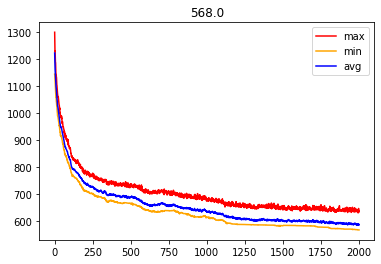

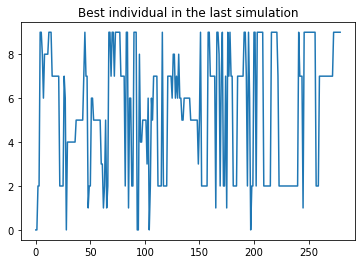

In [24]:
_ = n_simulations(n_sims=5, n_gens=2000, log_num_unique=False, should_remove_duplicates=True)

  0%|          | 0/5 [00:00<?, ?it/s]

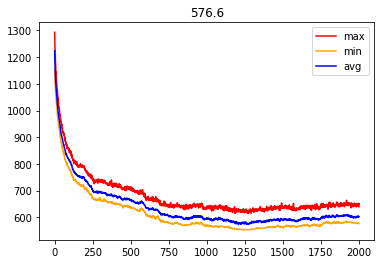

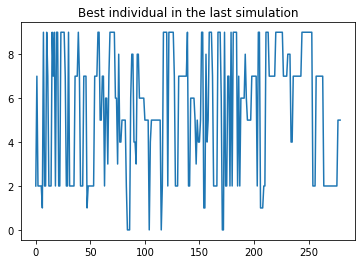

In [25]:
_ = n_simulations(n_sims=5, n_gens=2000, mutpb=0.4, log_num_unique=False, should_remove_duplicates=True)

  0%|          | 0/5 [00:00<?, ?it/s]

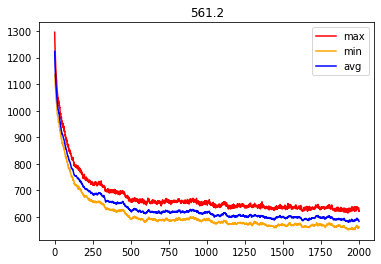

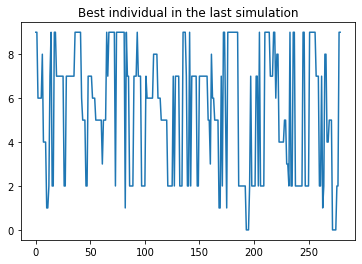

In [26]:
_ = n_simulations(n_sims=5, n_gens=2000, mutpb=0.5, log_num_unique=False, should_remove_duplicates=True)

  0%|          | 0/5 [00:00<?, ?it/s]

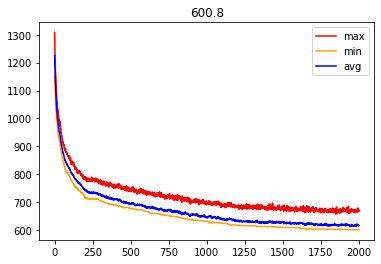

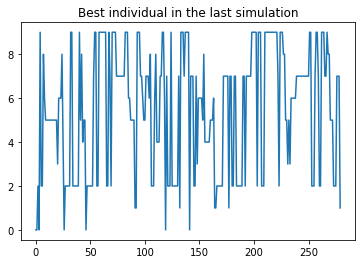

In [27]:
_ = n_simulations(n_sims=5, n_gens=2000, mutpb=0.2, log_num_unique=False, should_remove_duplicates=True)

# Initialization
Let's try different initialization strategies.

For example, 'base individual' has a very good fitness. Let's add it to the initial population. Other individuals are randomly generated.

In [28]:
print(f"fitness of base_individual: {-fitness(base_individual_indices)[0]}")
print(f"fitness of randomly initialized individual: {-fitness(np.random.permutation(base_individual_indices))[0]}")

fitness of base_individual: 323
fitness of randomly initialized individual: 1206


In [29]:
toolbox.register('population_before', tools.initRepeat, list, toolbox.individual)
def init_population(n):
    ind1 = creator.Individual(base_individual_indices)
    
    return toolbox.population_before(n=n-1) + [ind1]

toolbox.register('population', init_population)

We see that the best individual is lost in the firts stages of algorithm. It is bad because
* We don't have it as a result
* It doesn't contribute to evolution.
Elitism could be a saving option.

  0%|          | 0/5 [00:00<?, ?it/s]

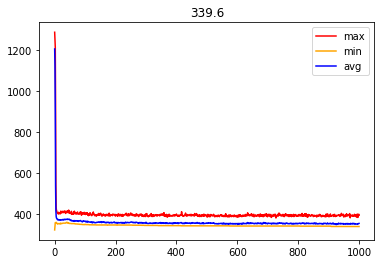

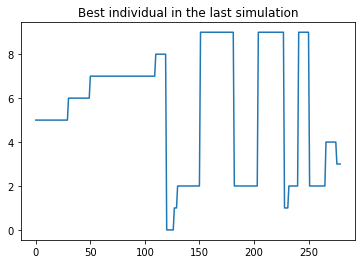

In [30]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate)
toolbox.register('select', tools.selTournament, tournsize=5)
_ = n_simulations(n_sims=5, n_gens=1000, log_num_unique=False, should_remove_duplicates=True)

Yes, elitism allows to save the best individual and even improve on it.

  0%|          | 0/5 [00:00<?, ?it/s]

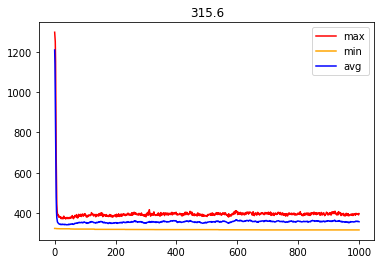

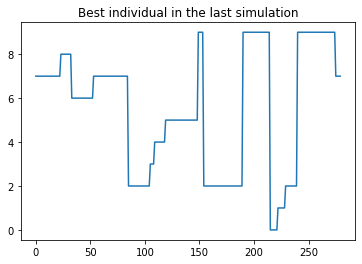

In [31]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate)
toolbox.register('select', tools.selTournament, tournsize=3)
_ = n_simulations(n_sims=5, n_gens=1000, log_num_unique=False, should_remove_duplicates=True, elitism=True)

## Initialization with the best randomly generated individuals

Another initialization strategy - generate more individuals and choose only the best of them as initial population.

In [32]:
toolbox.register('population_before', tools.initRepeat, list, toolbox.individual)
def init_population(n):
#     good_ind = creator.Individual(base_individual_indices)
    # Generate 5N individuals
    random_individuals = toolbox.population_before(n=5*n)
    # Calculate their fitnesses
    fitnesses = list(map(lambda x: -fitness(x)[0], random_individuals))
    sorted_inds = np.argsort(fitnesses)
    # Choose N best individuals
    random_individuals = np.array(random_individuals)
    random_individuals = random_individuals[sorted_inds][:n]
    random_individuals = list(map(creator.Individual, random_individuals))
    
    # Return them as initial population
    return random_individuals# + [good_ind]

toolbox.register('population', init_population)
    

Unfortunately, It doesn't give better results.

  0%|          | 0/5 [00:00<?, ?it/s]

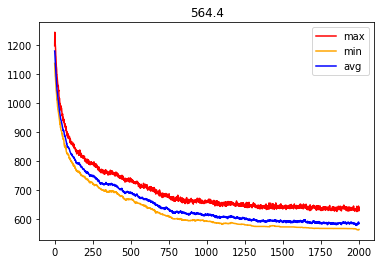

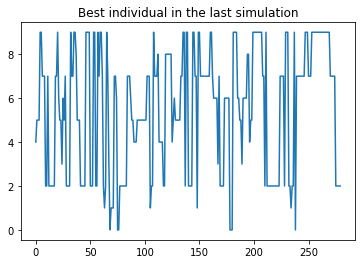

In [33]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate)
toolbox.register('select', tools.selTournament, tournsize=5)
hof = n_simulations(n_sims=5, n_gens=2000, log_num_unique=False, should_remove_duplicates=True, elitism=False)

  0%|          | 0/5 [00:00<?, ?it/s]

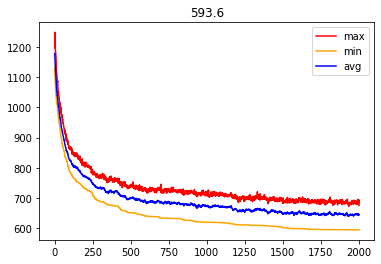

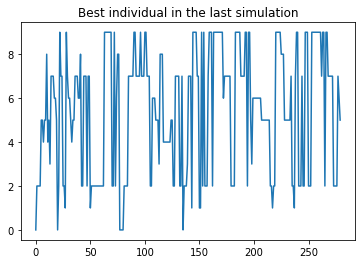

In [34]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate)
toolbox.register('select', tools.selTournament, tournsize=3)
hof = n_simulations(n_sims=5, n_gens=2000, log_num_unique=False, should_remove_duplicates=True, elitism=True)

## Initialization with the best result from another task

I'll change my fitness function to the scenario where there are no night cleanings and maintainance. It should be easier for EA, and the optimal result is the 'base_individual'. Then, I'll take this population and set it as the initial population for my main task.

In [35]:
def fitness(individual):
    value = 1
    for i in range(len(individual) - 1):
        i1 = base_individual[individual[i]]
        i2 = base_individual[individual[i + 1]]
        transition_cost = transitions[i1][i2]
        
        value += 1 + transition_cost
        
    return -value, # negative because algorithm will try to maximize fitness, 
                   # but we need to minimize this value

In [36]:
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate)
toolbox.register('select', tools.selTournament, tournsize=5)

  0%|          | 0/1 [00:00<?, ?it/s]

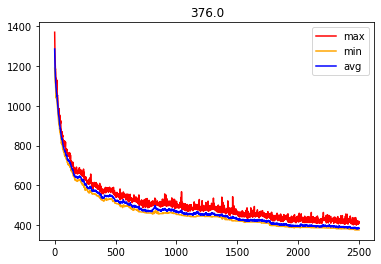

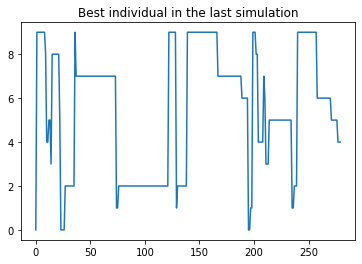

In [37]:
hof, pop = n_simulations(n_sims=1, n_gens=2500, log_num_unique=False, should_remove_duplicates=True, elitism=False)

In [38]:
toolbox.register('population_before', tools.initRepeat, list, toolbox.individual)
def init_population(n):
    return pop

toolbox.register('population', init_population)

In [39]:
def fitness(individual):
    value = 1
    for i in range(len(individual) - 1):
        i1 = base_individual[individual[i]]
        i2 = base_individual[individual[i + 1]]
        transition_cost = transitions[i1][i2]
        
        if (value + 1) % (3 * 20) == 0: # if it is the last slot in the day - no cleaning is required
            value += 1
        else:
            # if there are other slots and cleaning takes more than time of slots left - we do not need
            # to do all cleaning.
            value += 1 + min(
                60 - (value + 1) % (3 * 20), # time left until the end of the day.
                transition_cost)
        
    return -value, # negative because algorithm will try to maximize fitness, 
                   # but we need to minimize this value

The results improve over the baseline very much. However, it doesn't achive the same score as initialization with base individual.

  0%|          | 0/5 [00:00<?, ?it/s]

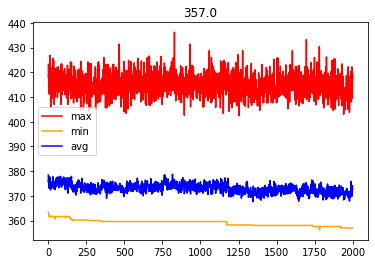

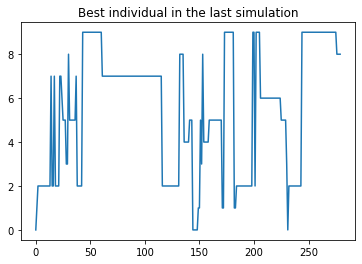

In [96]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate)
toolbox.register('select', tools.selTournament, tournsize=5)
_ = n_simulations(n_sims=5, n_gens=2000, log_num_unique=False, should_remove_duplicates=True, elitism=False)

Therefore, let's try to add the base individual to initialization

In [40]:
toolbox.register('population_before', tools.initRepeat, list, toolbox.individual)
def init_population(n):
    ind1 = creator.Individual(base_individual_indices)
    
    return pop[:-1] + [ind1]

toolbox.register('population', init_population)

  0%|          | 0/5 [00:00<?, ?it/s]

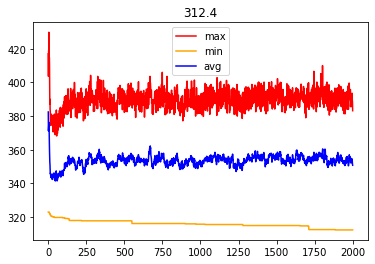

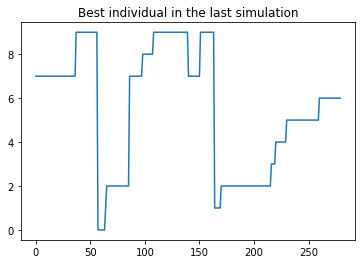

In [41]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate)
toolbox.register('select', tools.selTournament, tournsize=3)
_ = n_simulations(n_sims=5, n_gens=2000, log_num_unique=False, should_remove_duplicates=True, elitism=True)

Here I try just another mutation strategy. 

I change mutation such that it also rotates individual clock-wise + performs inversion. That allows to achieve a better placing for segments in final results.

In [42]:
def mutate1(ind):
    if random.random() < 0.3:
        ind, = mutate(ind)
    if random.random() < 0.3:
        m = random.randint(0, len(ind))
        ind = ind[m:] + ind[:m]
    if random.random() < 0.3:
        ind = ind[::-1]
                
    return creator.Individual(ind),

  0%|          | 0/5 [00:00<?, ?it/s]

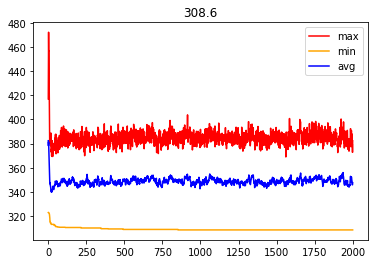

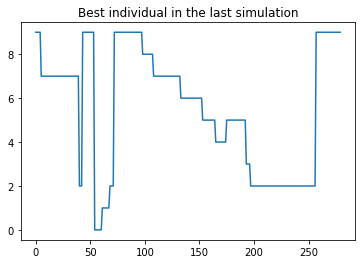

In [43]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate1)
toolbox.register('select', tools.selTournament, tournsize=3)
_ = n_simulations(n_sims=5, n_gens=2000, mutpb=0.4, log_num_unique=False, should_remove_duplicates=True, elitism=True)

# Final results
Let's take all best approaches and combine them in the final run. I also increase the population size and choose the best individual out of 50 runs.

The best result then is 300 time slots to fullfill the demand.

  0%|          | 0/50 [00:00<?, ?it/s]

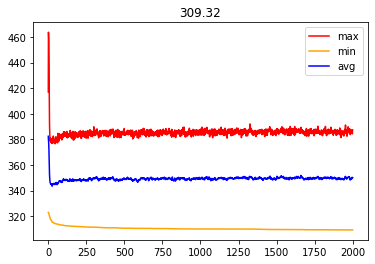

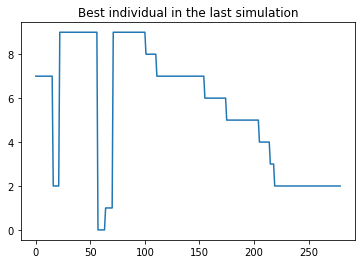

In [44]:
toolbox.register('evaluate', fitness)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', mutate1)
toolbox.register('select', tools.selTournament, tournsize=3)
best_ind, _ = n_simulations(npop=150, n_sims=50, n_gens=2000, mutpb=0.4, log_num_unique=False, should_remove_duplicates=True, elitism=True)

In [45]:
-fitness(best_ind)[0]

300